## Данные:
value – значения метрики\
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## Задачи:
Сравните результат между тестом и контролем по двум кейсам\
Внести выводы, которые можно сделать на основе анализа примененных критериев

In [78]:
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [23]:
df = pd.read_csv('./hw_bootstrap.csv', sep = ';')
df.value = df.value.str.replace(',', '.')
df.value = df.value.astype('float')

In [36]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [74]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


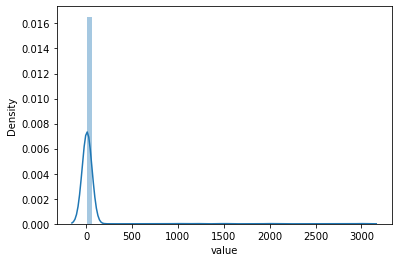

In [54]:
sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde = True)
#в распределении Treatment есть выбросы

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


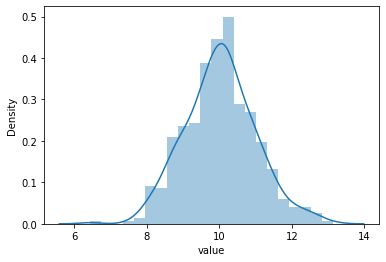

In [42]:
sns.distplot(df[df.experimentVariant == 'Control'].value, kde = True)

In [60]:
print(df[df.experimentVariant == 'Control'].value.mean(),
     df[df.experimentVariant == 'Treatment'].value.mean()) #средние значения

10.026866533804297 27.321499056661573


In [59]:
print(df[df.experimentVariant == 'Control'].value.median(),
     df[df.experimentVariant == 'Treatment'].value.median()) #медианы

10.0184651909296 10.02584684253515


In [38]:
ss.mannwhitneyu(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value)
#pvalue > 0.05 принимаем нулевую гипотезу о равенстве распределений

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

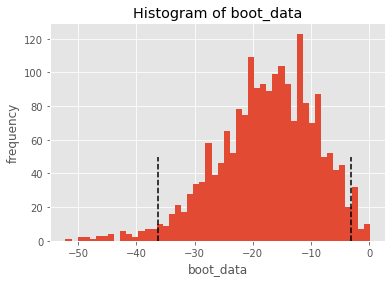

In [79]:
bod_mean = get_bootstrap(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value, boot_it = 2000, statistic = np.mean)

In [82]:
bod_mean['p_value'] #p_value средних значений

0.03956400525438217

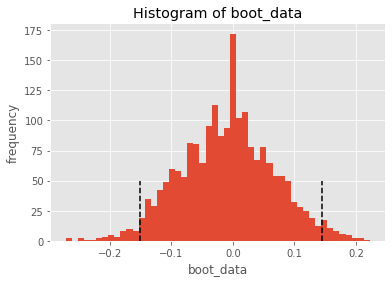

In [83]:
bod_median = get_bootstrap(df[df.experimentVariant == 'Control'].value, df[df.experimentVariant == 'Treatment'].value, boot_it = 2000, statistic = np.median)

In [84]:
bod_median['p_value'] #p_value медианных значений

0.9028382550873327

# Вывод:
1) P_value средних значений при применении метода bootstrap составил 0.039, а по методу Манна-Уитни 0.859. Исходя из оценки бутстрэпа нулевая гипотеза о равенстве распределений отклоняется, а по Манну-Уитни принимается. Это происходит потому что в данных присутствуют выбросы к которым чувствительно вычисление среднего значения, метод Манна-Уитни оценивает не сами значения, а их ранги, поэтому по нему гипотеза о равенстве распределений принимается.\
2) P_value медианных значений при применении метода bootstrap составил 0.902, а по методу Манна-Уитни 0.859. Медиана менее чувствительна к выбросным значением, и поэтому в обоих случах принимается нулевая гипотеза о равестве распределений. 